In [1]:
!pip install xrft==0.3.0
!pip install numpy_groupies

  Using cached xrft-0.3.0-py3-none-any.whl (23 kB)
  Attempting uninstall: xrft
    Found existing installation: xrft 0.2.3
    Uninstalling xrft-0.2.3:
      Successfully uninstalled xrft-0.2.3
  Using cached numpy_groupies-0.9.13-py3-none-any.whl


In [2]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:37485")
client

Client Scheduler: tcp://127.0.0.1:37485 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 64 Memory: 270.48 GB


In [25]:
client.restart()

Client Scheduler: tcp://127.0.0.1:37485 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 64 Memory: 270.48 GB


In [6]:
import numpy as np
import xarray as xr
import pandas as pd
from dask.diagnostics import ProgressBar
import xrft
import s3fs
import scipy.linalg as spl
from xgcm.grid import Grid
import matplotlib.colors as clr
import matplotlib.pyplot as plt
plt.rcParams['pcolor.shading'] = 'auto'
%matplotlib inline

In [19]:
import os
import gcsfs

gcs = gcsfs.GCSFileSystem(requester_pays=True)

SCRATCH = os.environ['SCRATCH_BUCKET']
SCRATCH

'gcs://meom-ige-scratch/roxyboy'

# Load data

In [8]:
endpoint_url = 'https://ncsa.osn.xsede.org'
fs_osn = s3fs.S3FileSystem(anon=True, client_kwargs={'endpoint_url': endpoint_url},)

url = "s3://Pangeo/pangeo-forge/swot_adac/eNATL60/"
enatl60_datasets = {
    ds: xr.open_zarr(fs_osn.get_mapper(f"{url}{ds}.zarr"), consolidated=True)
    for ds in ["Region02/surface_hourly/fma","Region02/surface_hourly/aso"]
}
enatl60_datasets

{'Region02/surface_hourly/fma': <xarray.Dataset>
 Dimensions:        (time_counter: 2136, x: 607, y: 735)
 Coordinates:
     depth          (y, x) float32 dask.array<chunksize=(735, 607), meta=np.ndarray>
     e1f            (y, x) float64 dask.array<chunksize=(735, 607), meta=np.ndarray>
     e1t            (y, x) float64 dask.array<chunksize=(735, 607), meta=np.ndarray>
     e1u            (y, x) float64 dask.array<chunksize=(735, 607), meta=np.ndarray>
     e1v            (y, x) float64 dask.array<chunksize=(735, 607), meta=np.ndarray>
     e2f            (y, x) float64 dask.array<chunksize=(735, 607), meta=np.ndarray>
     e2t            (y, x) float64 dask.array<chunksize=(735, 607), meta=np.ndarray>
     e2u            (y, x) float64 dask.array<chunksize=(735, 607), meta=np.ndarray>
     e2v            (y, x) float64 dask.array<chunksize=(735, 607), meta=np.ndarray>
     lat            (y, x) float32 dask.array<chunksize=(735, 607), meta=np.ndarray>
     lon            (y, x) flo

In [61]:
endpoint_url = 'https://ncsa.osn.xsede.org'
fs_osn = s3fs.S3FileSystem(anon=True, client_kwargs={'endpoint_url': endpoint_url},)

url = "s3://Pangeo/pangeo-forge/swot_adac/HYCOM50/"
hycom50_datasets = {
    ds: xr.open_zarr(fs_osn.get_mapper(f"{url}{ds}.zarr"), consolidated=True, decode_times=False)
    for ds in ["Region02_GE/surf/fma","Region02_GE/surf/aso"]
}
hycom50_datasets

{'Region02_GE/surf/fma': <xarray.Dataset>
 Dimensions:    (lat: 615, lon: 503, time: 2160)
 Coordinates:
   * time       (time) int64 0 1 2 3 4 5 6 ... 2153 2154 2155 2156 2157 2158 2159
 Dimensions without coordinates: lat, lon
 Data variables:
     latitude   (lat) float32 dask.array<chunksize=(615,), meta=np.ndarray>
     longitude  (lon) float32 dask.array<chunksize=(503,), meta=np.ndarray>
     ssh        (time, lat, lon) float32 dask.array<chunksize=(24, 615, 503), meta=np.ndarray>
     sss        (time, lat, lon) float32 dask.array<chunksize=(24, 615, 503), meta=np.ndarray>
     sst        (time, lat, lon) float32 dask.array<chunksize=(24, 615, 503), meta=np.ndarray>
     tauewd     (time, lat, lon) float32 dask.array<chunksize=(24, 615, 503), meta=np.ndarray>
     taunwd     (time, lat, lon) float32 dask.array<chunksize=(24, 615, 503), meta=np.ndarray>
     uu1        (time, lat, lon) float32 dask.array<chunksize=(24, 615, 503), meta=np.ndarray>
     vv1        (time, lat, lon)

In [8]:
winter = np.concatenate((np.concatenate((np.repeat(2,696),
                                         np.repeat(3,744))),
                         np.repeat(4,720)))
summer = np.concatenate((np.concatenate((np.repeat(8,744),
                                         np.repeat(9,720))),
                         np.repeat(10,744)))
summer

array([ 8,  8,  8, ..., 10, 10, 10])

In [62]:
endpoint_url = 'https://ncsa.osn.xsede.org'
fs_osn = s3fs.S3FileSystem(anon=True, client_kwargs={'endpoint_url': endpoint_url},)

url = "s3://Pangeo/pangeo-forge/swot_adac/HYCOM50/"
hycom50_grids = {
    grid: xr.open_zarr(fs_osn.get_mapper(f"{url}{grid}.zarr"), consolidated=True)
    for grid in ["grid_02"]
}

hycom50_grids

{'grid_02': <xarray.Dataset>
 Dimensions:    (lat: 615, lon: 503)
 Dimensions without coordinates: lat, lon
 Data variables:
     depth      (lat, lon) float64 dask.array<chunksize=(615, 503), meta=np.ndarray>
     latitude   (lat) float64 dask.array<chunksize=(615,), meta=np.ndarray>
     longitude  (lon) float64 dask.array<chunksize=(503,), meta=np.ndarray>}

In [7]:
# Functions to adapt croco outputs to xgcm
##########################################

def adjust_coords(ds):

    if 'nav_lon_u' not in ds.coords:
        ##########################
        # for regular CROCO files:
        ds = ds.set_coords([c for c in ds.variables if 'lon' in c or 'lat' in c ])

    else:
        ##########################
        # for XIOS files:
        
        ds = ds.rename({'time_counter': 'time'})
        
        ds = ds.reset_coords([c for c in ds.coords if 'nav' in c])

        # rename redundant dimensions
        _dims = (d for d in ['x_v', 'y_u', 'x_w', 'y_w'] if d in ds.dims)
        for d in _dims:
            ds = ds.rename({d: d[0]+'_rho'})

        # change axis names to xi,eta (instead of x,y)
        _dims = (d for d in ['x_u', 'x_rho'] if d in ds.dims)
        for d in _dims:
            ds = ds.rename({d: 'xi' + d[1:]}) 

        _dims = (d for d in ['y_v', 'y_rho'] if d in ds.dims)
        for d in _dims:
            ds = ds.rename({d: 'eta' + d[1:]}) 


        # change nav variables to coordinates        
        _coords = [d for d in [d for d in ds.data_vars.keys()] if "nav_" in d]
        ds = ds.set_coords(_coords) 

        # rename coordinates 
        eta_suff={}
        for c in ds.coords:
            new_c = c.replace('nav_lat','lat').replace('nav_lon','lon')
            ds = ds.rename({c:new_c})
            # reset names and units
            ds[new_c] = (ds[new_c].assign_attrs(units='deg', 
                                               standard_name=new_c,
                                               long_name=new_c)
                        )

    ##########################
    # For all types  
    if 'eta_psi' in ds.dims: ds = ds.rename({'eta_psi': 'eta_v'}) 
    if 'xi_psi' in ds.dims: ds = ds.rename({'xi_psi': 'xi_u'}) 
        

    ##########################
    # Create xgcm grid
    coords={'xi':{'center':'xi_rho', 'inner':'xi_u'}, 
            'eta':{'center':'eta_rho', 'inner':'eta_v'}, 
            's':{'center':'s_rho', 'outer':'s_w'}}

    ds.attrs['xgcm-Grid'] = Grid(ds, coords=coords, periodic=[])


    return ds

    
def add_grd(ds,grd):
    
    ##########################
    for variable in grd.data_vars.keys():
        #print(variable)
        ds[variable] = grd[variable]
        
    ds['mask_rho'] = ds.mask_rho.where(ds.mask_rho>0,np.nan)
    
    if 'lon_psi' not in ds.coords: 
        #ds['lon_psi'] = grd['lon_psi']
        #ds['lat_psi'] = grd['lat_psi']
        ds = ds.assign_coords({'lon_psi':grd['lon_psi'], 'lat_psi':grd['lat_psi']})

    return ds
 
    ########
    
endpoint_url = 'https://ncsa.osn.xsede.org'
fs_osn = s3fs.S3FileSystem(anon=True, client_kwargs={'endpoint_url': endpoint_url},)

url = "s3://Pangeo/pangeo-forge/swot_adac/GIGATL/"
gigatl_datasets = {
    ds: adjust_coords(xr.open_zarr(fs_osn.get_mapper(f"{url}{ds}.zarr"), consolidated=True))
    for ds in ["Region02/surf/fma","Region02/surf/aso"]
}

gigatl_datasets

{'Region02/surf/fma': <xarray.Dataset>
 Dimensions:     (eta_rho: 1411, eta_v: 1410, time: 2280, xi_rho: 1331, xi_u: 1330)
 Coordinates:
     lat         (eta_rho, xi_rho) float32 dask.array<chunksize=(1411, 1331), meta=np.ndarray>
     lon         (eta_rho, xi_rho) float32 dask.array<chunksize=(1411, 1331), meta=np.ndarray>
 Dimensions without coordinates: eta_rho, eta_v, time, xi_rho, xi_u
 Data variables:
     angle       (eta_rho, xi_rho) float32 dask.array<chunksize=(1411, 1331), meta=np.ndarray>
     f           (eta_rho, xi_rho) float32 dask.array<chunksize=(1411, 1331), meta=np.ndarray>
     h           (eta_rho, xi_rho) float32 dask.array<chunksize=(1411, 1331), meta=np.ndarray>
     ocean_time  (time) float32 dask.array<chunksize=(24,), meta=np.ndarray>
     pm          (eta_rho, xi_rho) float32 dask.array<chunksize=(1411, 1331), meta=np.ndarray>
     pn          (eta_rho, xi_rho) float32 dask.array<chunksize=(1411, 1331), meta=np.ndarray>
     salt        (time, eta_rho, xi_

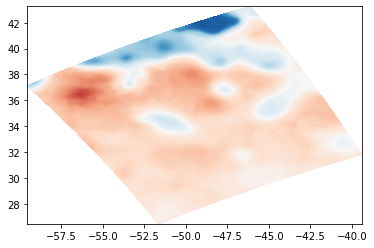

In [41]:
plt.pcolormesh(gigatl_datasets["Region02/surf/fma"].lon,
               gigatl_datasets["Region02/surf/fma"].lat,
               gigatl_datasets["Region02/surf/fma"].zeta.isel(time=0),
               vmax=1, vmin=-1, cmap='RdBu_r'
              )

In [28]:
from xmitgcm import llcreader
model = llcreader.ECCOPortalLLC2160Model()
print(model.varnames)

['Eta', 'KPPhbl', 'oceFWflx', 'oceQnet', 'oceQsw', 'oceSflux', 'oceTAUX', 'oceTAUY', 'PhiBot', 'Salt', 'SIarea', 'SIheff', 'SIhsalt', 'SIhsnow', 'SIuice', 'SIvice', 'Theta', 'U', 'V', 'W']


In [29]:
llc02w = model.get_dataset(varnames=['U','V','Eta'], k_levels=[0], 
                           type='latlon').sel(time=slice('2012-02-01','2012-04-30'),
                                              j=slice(4778,5098),j_g=slice(4778,5098),
                                              i=slice(8255,8496),i_g=slice(8255,8496),
                                              k=0)
llc02w

<xarray.Dataset>
Dimensions:  (face: 13, i: 242, i_g: 242, j: 321, j_g: 321, k_l: 1, k_p1: 2, k_u: 1, time: 2160)
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 8255 8256 8257 8258 8259 ... 8492 8493 8494 8495 8496
  * i_g      (i_g) int64 8255 8256 8257 8258 8259 ... 8492 8493 8494 8495 8496
  * j        (j) int64 4778 4779 4780 4781 4782 ... 5094 5095 5096 5097 5098
  * j_g      (j_g) int64 4778 4779 4780 4781 4782 ... 5094 5095 5096 5097 5098
    k        int64 0
  * k_u      (k_u) int64 0
  * k_l      (k_l) int64 0
  * k_p1     (k_p1) int64 0 1
  * time     (time) datetime64[ns] 2012-02-01 ... 2012-04-30T23:00:00
    CS       (j, i) float32 dask.array<chunksize=(321, 242), meta=np.ndarray>
    SN       (j, i) float32 dask.array<chunksize=(321, 242), meta=np.ndarray>
    Depth    (j, i) float32 dask.array<chunksize=(321, 242), meta=np.ndarray>
    drC      (k_p1) >f4 dask.array<chunksize=(2,), meta=np.ndarray>
    drF      >f4 dask.array<chunksize=(), meta=np.ndarray>
    dxC      (j, i_g) float32 dask.array<chunksize=(321, 242), meta=np.ndarray>
    dxF      (j, i) float32 dask.array<chunksize=(321, 242), meta=np.ndarray>
    dxG      (j_g, i) float32 dask.array<chunksize=(321, 242), meta=np.ndarray>
    dyC      (j_g, i) float32 dask.array<chunksize=(321, 242), meta=np.ndarray>
    dyF      (j, i) float32 dask.array<chunksize=(321, 242), meta=np.ndarray>
    dyG      (j, i_g) float32 dask.array<chunksize=(321, 242), meta=np.ndarray>
    hFacC    (j, i) float32 dask.array<chunksize=(321, 242), meta=np.ndarray>
    hFacS    (j_g, i) float32 dask.array<chunksize=(321, 242), meta=np.ndarray>
    hFacW    (j, i_g) float32 dask.array<chunksize=(321, 242), meta=np.ndarray>
    PHrefC   >f4 dask.array<chunksize=(), meta=np.ndarray>
    PHrefF   (k_p1) >f4 dask.array<chunksize=(2,), meta=np.ndarray>
    rA       (j, i) float32 dask.array<chunksize=(321, 242), meta=np.ndarray>
    rAs      (j_g, i) float32 dask.array<chunksize=(321, 242), meta=np.ndarray>
    rAw      (j, i_g) float32 dask.array<chunksize=(321, 242), meta=np.ndarray>
    Z        >f4 dask.array<chunksize=(), meta=np.ndarray>
    Zp1      (k_p1) >f4 dask.array<chunksize=(2,), meta=np.ndarray>
    rhoRef   >f4 dask.array<chunksize=(), meta=np.ndarray>
    rLowC    (j, i) float32 dask.array<chunksize=(321, 242), meta=np.ndarray>
    rLowS    (j_g, i) float32 dask.array<chunksize=(321, 242), meta=np.ndarray>
    rLowW    (j, i_g) float32 dask.array<chunksize=(321, 242), meta=np.ndarray>
    rSurfC   (j, i) float32 dask.array<chunksize=(321, 242), meta=np.ndarray>
    rSurfS   (j_g, i) float32 dask.array<chunksize=(321, 242), meta=np.ndarray>
    rSurfW   (j, i_g) float32 dask.array<chunksize=(321, 242), meta=np.ndarray>
    XC       (j, i) float32 dask.array<chunksize=(321, 242), meta=np.ndarray>
    YC       (j, i) float32 dask.array<chunksize=(321, 242), meta=np.ndarray>
    rAz      (j_g, i_g) float32 dask.array<chunksize=(321, 242), meta=np.ndarray>
    XG       (j_g, i_g) float32 dask.array<chunksize=(321, 242), meta=np.ndarray>
    YG       (j_g, i_g) float32 dask.array<chunksize=(321, 242), meta=np.ndarray>
    dxV      (j_g, i_g) float32 dask.array<chunksize=(321, 242), meta=np.ndarray>
    dyU      (j_g, i_g) float32 dask.array<chunksize=(321, 242), meta=np.ndarray>
    Zl       (k_l) >f4 dask.array<chunksize=(1,), meta=np.ndarray>
    Zu       (k_u) >f4 dask.array<chunksize=(1,), meta=np.ndarray>
Data variables:
    U        (time, j, i_g) float32 dask.array<chunksize=(1, 321, 242), meta=np.ndarray>
    V        (time, j_g, i) float32 dask.array<chunksize=(1, 321, 242), meta=np.ndarray>
    Eta      (time, j, i) float32 dask.array<chunksize=(1, 321, 242), meta=np.ndarray>

In [30]:
llc02s = model.get_dataset(varnames=['U','V','Eta'], k_levels=[0], 
                           type='latlon').sel(time=slice('2011-08-01','2011-10-31'),
                                              j=slice(4778,5098),j_g=slice(4778,5098),
                                              i=slice(8255,8496),i_g=slice(8255,8496),
                                              k=0)
llc02s

<xarray.Dataset>
Dimensions:  (face: 13, i: 242, i_g: 242, j: 321, j_g: 321, k_l: 1, k_p1: 2, k_u: 1, time: 2208)
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 8255 8256 8257 8258 8259 ... 8492 8493 8494 8495 8496
  * i_g      (i_g) int64 8255 8256 8257 8258 8259 ... 8492 8493 8494 8495 8496
  * j        (j) int64 4778 4779 4780 4781 4782 ... 5094 5095 5096 5097 5098
  * j_g      (j_g) int64 4778 4779 4780 4781 4782 ... 5094 5095 5096 5097 5098
    k        int64 0
  * k_u      (k_u) int64 0
  * k_l      (k_l) int64 0
  * k_p1     (k_p1) int64 0 1
  * time     (time) datetime64[ns] 2011-08-01 ... 2011-10-31T23:00:00
    CS       (j, i) float32 dask.array<chunksize=(321, 242), meta=np.ndarray>
    SN       (j, i) float32 dask.array<chunksize=(321, 242), meta=np.ndarray>
    Depth    (j, i) float32 dask.array<chunksize=(321, 242), meta=np.ndarray>
    drC      (k_p1) >f4 dask.array<chunksize=(2,), meta=np.ndarray>
    drF      >f4 dask.array<chunksize=(), meta=np.ndarray>
    dxC      (j, i_g) float32 dask.array<chunksize=(321, 242), meta=np.ndarray>
    dxF      (j, i) float32 dask.array<chunksize=(321, 242), meta=np.ndarray>
    dxG      (j_g, i) float32 dask.array<chunksize=(321, 242), meta=np.ndarray>
    dyC      (j_g, i) float32 dask.array<chunksize=(321, 242), meta=np.ndarray>
    dyF      (j, i) float32 dask.array<chunksize=(321, 242), meta=np.ndarray>
    dyG      (j, i_g) float32 dask.array<chunksize=(321, 242), meta=np.ndarray>
    hFacC    (j, i) float32 dask.array<chunksize=(321, 242), meta=np.ndarray>
    hFacS    (j_g, i) float32 dask.array<chunksize=(321, 242), meta=np.ndarray>
    hFacW    (j, i_g) float32 dask.array<chunksize=(321, 242), meta=np.ndarray>
    PHrefC   >f4 dask.array<chunksize=(), meta=np.ndarray>
    PHrefF   (k_p1) >f4 dask.array<chunksize=(2,), meta=np.ndarray>
    rA       (j, i) float32 dask.array<chunksize=(321, 242), meta=np.ndarray>
    rAs      (j_g, i) float32 dask.array<chunksize=(321, 242), meta=np.ndarray>
    rAw      (j, i_g) float32 dask.array<chunksize=(321, 242), meta=np.ndarray>
    Z        >f4 dask.array<chunksize=(), meta=np.ndarray>
    Zp1      (k_p1) >f4 dask.array<chunksize=(2,), meta=np.ndarray>
    rhoRef   >f4 dask.array<chunksize=(), meta=np.ndarray>
    rLowC    (j, i) float32 dask.array<chunksize=(321, 242), meta=np.ndarray>
    rLowS    (j_g, i) float32 dask.array<chunksize=(321, 242), meta=np.ndarray>
    rLowW    (j, i_g) float32 dask.array<chunksize=(321, 242), meta=np.ndarray>
    rSurfC   (j, i) float32 dask.array<chunksize=(321, 242), meta=np.ndarray>
    rSurfS   (j_g, i) float32 dask.array<chunksize=(321, 242), meta=np.ndarray>
    rSurfW   (j, i_g) float32 dask.array<chunksize=(321, 242), meta=np.ndarray>
    XC       (j, i) float32 dask.array<chunksize=(321, 242), meta=np.ndarray>
    YC       (j, i) float32 dask.array<chunksize=(321, 242), meta=np.ndarray>
    rAz      (j_g, i_g) float32 dask.array<chunksize=(321, 242), meta=np.ndarray>
    XG       (j_g, i_g) float32 dask.array<chunksize=(321, 242), meta=np.ndarray>
    YG       (j_g, i_g) float32 dask.array<chunksize=(321, 242), meta=np.ndarray>
    dxV      (j_g, i_g) float32 dask.array<chunksize=(321, 242), meta=np.ndarray>
    dyU      (j_g, i_g) float32 dask.array<chunksize=(321, 242), meta=np.ndarray>
    Zl       (k_l) >f4 dask.array<chunksize=(1,), meta=np.ndarray>
    Zu       (k_u) >f4 dask.array<chunksize=(1,), meta=np.ndarray>
Data variables:
    U        (time, j, i_g) float32 dask.array<chunksize=(1, 321, 242), meta=np.ndarray>
    V        (time, j_g, i) float32 dask.array<chunksize=(1, 321, 242), meta=np.ndarray>
    Eta      (time, j, i) float32 dask.array<chunksize=(1, 321, 242), meta=np.ndarray>

In [32]:
metrics = {
    ('X',): ['dxC', 'dxG'], # X distances
    ('Y',): ['dyC', 'dyG'], # Y distances
    ('Z',): ['drC'], # Z distances
    ('X', 'Y'): ['rA', 'rAs', 'rAw'] # Areas
}

gridl = Grid(llc02w, periodic=[],
             coords={'Y':{'center':'j','left':'j_g'},
                     'X':{'center':'i','left':'i_g'},
                     'Z':{'center':'k','outer':'k_p1'}
                     },
             metrics=metrics
            )
gridl

<xgcm.Grid>
Y Axis (not periodic, boundary=None):
  * center   j --> left
  * left     j_g --> center
X Axis (not periodic, boundary=None):
  * center   i --> left
  * left     i_g --> center
Z Axis (not periodic, boundary=None):
  * center   k --> outer
  * outer    k_p1 --> center

# Assume local Cartesian plane
## Sea-surface height

In [21]:
enatl02s = enatl60_datasets["Region02/surface_hourly/aso"]
Ny = len(enatl02s.y)
Nx = len(enatl02s.x)
dx = enatl02s.e1t.mean(skipna=True)
dy = enatl02s.e2t.mean(skipna=True)

if 1/(2*dx) > 1/(2*dy):
    Kenatl = 1/(2*dy)
else:
    Kenatl = 1/(2*dx)
enatl02s_H = xr.DataArray(enatl02s.sossheig.data, dims=['time','YC','XC'],
                          coords={'time':np.arange(len(enatl02s.time_counter))*3600,
                                  'YC':np.arange(0,Ny*dy,dy),
                                  'XC':np.arange(0,Nx*dx,dx)}
                         ).chunk({'time':1})
enatl02s_H

<xarray.DataArray 'xarray-sossheig-db3a2c9e3feaf2cc450af84457330ef6' (time: 1464, YC: 735, XC: 607)>
dask.array<rechunk-merge, shape=(1464, 735, 607), dtype=float32, chunksize=(1, 735, 607), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) int64 0 3600 7200 10800 ... 5256000 5259600 5263200 5266800
  * YC       (YC) float64 0.0 1.501e+03 3.002e+03 ... 1.1e+06 1.102e+06
  * XC       (XC) float64 0.0 1.509e+03 3.017e+03 ... 9.126e+05 9.142e+05

In [22]:
enatl02w = enatl60_datasets["Region02/surface_hourly/fma"]
Ny = len(enatl02w.y)
Nx = len(enatl02w.x)
dx = enatl02w.e1t.mean(skipna=True)
dy = enatl02w.e2t.mean(skipna=True)

if 1/(2*dx) > 1/(2*dy):
    Kenatl = 1/(2*dy)
else:
    Kenatl = 1/(2*dx)
enatl02w_H = xr.DataArray(enatl02w.sossheig.data, dims=['time','YC','XC'],
                          coords={'time':np.arange(len(enatl02w.time_counter))*3600,
                                  'YC':np.arange(0,Ny*dy,dy),
                                  'XC':np.arange(0,Nx*dx,dx)}
                         ).chunk({'time':1})
enatl02w_H

<xarray.DataArray 'xarray-sossheig-e240a84ad4d19a2d05905a6fd0d09e70' (time: 2136, YC: 735, XC: 607)>
dask.array<rechunk-merge, shape=(2136, 735, 607), dtype=float32, chunksize=(1, 735, 607), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) int64 0 3600 7200 10800 ... 7675200 7678800 7682400 7686000
  * YC       (YC) float64 0.0 1.501e+03 3.002e+03 ... 1.1e+06 1.102e+06
  * XC       (XC) float64 0.0 1.509e+03 3.017e+03 ... 9.126e+05 9.142e+05

Text(0, 0.5, '[km]')

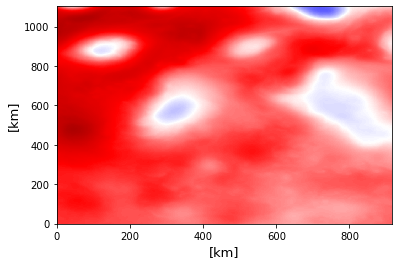

In [35]:
fig, ax = plt.subplots()

ax.pcolormesh(enatl02w_H.isel(time=0).XC*1e-3, enatl02w_H.isel(time=0).YC*1e-3,
              enatl02w_H.isel(time=0), cmap='seismic', vmax=1., vmin=-1.)

ax.set_xlabel("[km]", fontsize=13)
ax.set_ylabel("[km]", fontsize=13)

In [63]:
hycom02w = hycom50_datasets["Region02_GE/surf/fma"]
Ny = len(hycom50_grids["grid_02"].lat)
Nx = len(hycom50_grids["grid_02"].lon)
import gsw
xx, yy = np.meshgrid(hycom50_grids["grid_02"].longitude, hycom50_grids["grid_02"].latitude)
dx = xr.DataArray(gsw.distance(xx, yy), dims=['lat','lon'],
                  coords={'lat':np.arange(615),'lon':np.arange(.5,502,1)}
                 ).interp(lon=np.arange(503), method="linear",
                          kwargs={"fill_value": "extrapolate"}).mean()
dy = xr.DataArray(gsw.distance(xx, yy, axis=0), dims=['lat','lon'],
                  coords={'lat':np.arange(.5,614,1),'lon':np.arange(503)}
                 ).interp(lat=np.arange(615), method="linear",
                          kwargs={"fill_value": "extrapolate"}).mean()
if 1/(2*dx) > 1/(2*dy):
    Khycom = 1/(2*dy)
else:
    Khycom = 1/(2*dx)
hycom02w_H = xr.DataArray(hycom02w.ssh.data*1e-2, dims=['time','YC','XC'],
                          coords={'time':np.arange(len(hycom02w.time))*3600,
                                  'YC':np.arange(0,Ny*dy,dy),
                                  'XC':np.arange(0,Nx*dx,dx),
#                                   'month':('time',winter)
                                 }
                         ).chunk({'time':1})

hycom02w_H

<xarray.DataArray 'mul-4fcb0113a4dd0d835e783c9f795b8638' (time: 2160, YC: 615, XC: 503)>
dask.array<rechunk-merge, shape=(2160, 615, 503), dtype=float32, chunksize=(1, 615, 503), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) int64 0 3600 7200 10800 ... 7761600 7765200 7768800 7772400
  * YC       (YC) float64 0.0 1.817e+03 3.634e+03 ... 1.114e+06 1.116e+06
  * XC       (XC) float64 0.0 1.817e+03 3.634e+03 ... 9.103e+05 9.121e+05

In [64]:
hycom02s = hycom50_datasets["Region02_GE/surf/aso"]
Ny = len(hycom50_grids["grid_02"].lat)
Nx = len(hycom50_grids["grid_02"].lon)
import gsw
xx, yy = np.meshgrid(hycom50_grids["grid_02"].longitude, hycom50_grids["grid_02"].latitude)
dx = xr.DataArray(gsw.distance(xx, yy), dims=['lat','lon'],
                  coords={'lat':np.arange(615),'lon':np.arange(.5,502,1)}
                 ).interp(lon=np.arange(503), method="linear",
                          kwargs={"fill_value": "extrapolate"}).mean()
dy = xr.DataArray(gsw.distance(xx, yy, axis=0), dims=['lat','lon'],
                  coords={'lat':np.arange(.5,614,1),'lon':np.arange(503)}
                 ).interp(lat=np.arange(615), method="linear",
                          kwargs={"fill_value": "extrapolate"}).mean()
if 1/(2*dx) > 1/(2*dy):
    Khycom = 1/(2*dy)
else:
    Khycom = 1/(2*dx)
hycom02s_H = xr.DataArray(hycom02s.ssh.data*1e-2, dims=['time','YC','XC'],
                          coords={'time':np.arange(len(hycom02s.time))*3600,
                                  'YC':np.arange(0,Ny*dy,dy),
                                  'XC':np.arange(0,Nx*dx,dx),
#                                   'month':('time',winter)
                                 }
                         ).chunk({'time':1})

hycom02s_H

<xarray.DataArray 'mul-ea0785b40df0a2074965d7dc100da47b' (time: 2208, YC: 615, XC: 503)>
dask.array<rechunk-merge, shape=(2208, 615, 503), dtype=float32, chunksize=(1, 615, 503), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) int64 0 3600 7200 10800 ... 7934400 7938000 7941600 7945200
  * YC       (YC) float64 0.0 1.817e+03 3.634e+03 ... 1.114e+06 1.116e+06
  * XC       (XC) float64 0.0 1.817e+03 3.634e+03 ... 9.103e+05 9.121e+05

Text(0, 0.5, '[km]')

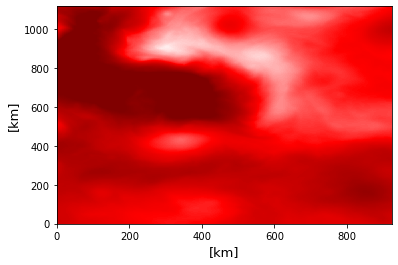

In [34]:
fig, ax = plt.subplots()

ax.pcolormesh(hycom02w_H.isel(time=0).XC*1e-3, hycom02w_H.isel(time=0).YC*1e-3,
              hycom02w_H.isel(time=0), cmap='seismic', vmax=1., vmin=-1.)

ax.set_xlabel("[km]", fontsize=13)
ax.set_ylabel("[km]", fontsize=13)

In [10]:
gigatl02w = gigatl_datasets["Region02/surf/fma"]
gridg = gigatl02w.attrs["xgcm-Grid"]
Ny = len(gigatl02w.eta_rho)
Nx = len(gigatl02w.xi_rho)
dx = (gigatl02w.pm**-1).mean(skipna=True)
dy = (gigatl02w.pn**-1).mean(skipna=True)

if 1/(2*dx) > 1/(2*dy):
    Kgigatl = 1/(2*dy)
else:
    Kgigatl = 1/(2*dx)
gigatl02w_H = xr.DataArray(gigatl02w.zeta.data, dims=['time','YC','XC'],
                           coords={'time':np.arange(len(gigatl02w.time))*3600,
                                   'YC':np.arange(0,(Ny)*dy,dy),
                                   'XC':np.arange(0,(Nx)*dx,dx)}
                          )

gigatl02w_H

<xarray.DataArray 'xarray-zeta-6a8c72c19a02012ec0c12621d75725bc' (time: 2280, YC: 1411, XC: 1331)>
dask.array<xarray-zeta, shape=(2280, 1411, 1331), dtype=float32, chunksize=(24, 1411, 1331), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) int64 0 3600 7200 10800 ... 8193600 8197200 8200800 8204400
  * YC       (YC) float64 0.0 998.1 1.996e+03 ... 1.405e+06 1.406e+06 1.407e+06
  * XC       (XC) float64 0.0 998.1 1.996e+03 ... 1.325e+06 1.326e+06 1.327e+06

In [11]:
gigatl02s = gigatl_datasets["Region02/surf/aso"]
gridg = gigatl02s.attrs["xgcm-Grid"]
Ny = len(gigatl02s.eta_rho)
Nx = len(gigatl02s.xi_rho)
dx = (gigatl02s.pm**-1).mean(skipna=True)
dy = (gigatl02s.pn**-1).mean(skipna=True)

if 1/(2*dx) > 1/(2*dy):
    Kgigatl = 1/(2*dy)
else:
    Kgigatl = 1/(2*dx)
gigatl02s_H = xr.DataArray(gigatl02s.zeta.data, dims=['time','YC','XC'],
                           coords={'time':np.arange(len(gigatl02s.time))*3600,
                                   'YC':np.arange(0,(Ny)*dy,dy),
                                   'XC':np.arange(0,(Nx)*dx,dx)}
                          )

gigatl02s_H

<xarray.DataArray 'xarray-zeta-1e4c6930e096a796725b0f8ba7771e09' (time: 2280, YC: 1411, XC: 1331)>
dask.array<xarray-zeta, shape=(2280, 1411, 1331), dtype=float32, chunksize=(24, 1411, 1331), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) int64 0 3600 7200 10800 ... 8193600 8197200 8200800 8204400
  * YC       (YC) float64 0.0 998.1 1.996e+03 ... 1.405e+06 1.406e+06 1.407e+06
  * XC       (XC) float64 0.0 998.1 1.996e+03 ... 1.325e+06 1.326e+06 1.327e+06

Text(0, 0.5, '[km]')

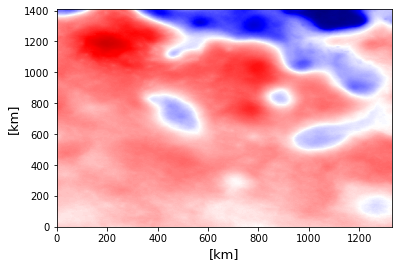

In [33]:
fig, ax = plt.subplots()

ax.pcolormesh(gigatl02w_H.isel(time=0).XC*1e-3, gigatl02w_H.isel(time=0).YC*1e-3,
              gigatl02w_H.isel(time=0), cmap='seismic', vmax=1., vmin=-1.)

ax.set_xlabel("[km]", fontsize=13)
ax.set_ylabel("[km]", fontsize=13)

In [41]:
Ny = len(llc02s.j)
Nx = len(llc02s.i)
dx = llc02s.dxC.mean(skipna=True)
dy = llc02s.dyC.mean(skipna=True)

if 1/(2*dx) > 1/(2*dy):
    Kllc = 1/(2*dy)
else:
    Kllc = 1/(2*dx)
llc02s_H = xr.DataArray(llc02s.Eta.data, dims=['time','YC','XC'],
                        coords={'time':np.arange(len(llc02s.time))*3600,
                                'YC':np.arange(0,(Ny)*dy,dy),
                                'XC':np.arange(0,(Nx)*dx,dx)}
                       ).chunk({'time':1})

llc02s_H

<xarray.DataArray 'getitem-3b94cbb789d5d75d3844e17ffff9afea' (time: 2208, YC: 321, XC: 242)>
dask.array<getitem, shape=(2208, 321, 242), dtype=float32, chunksize=(1, 321, 242), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) int64 0 3600 7200 10800 ... 7934400 7938000 7941600 7945200
  * YC       (YC) float64 0.0 3.785e+03 7.571e+03 ... 1.208e+06 1.211e+06
  * XC       (XC) float64 0.0 3.491e+03 6.983e+03 ... 8.38e+05 8.414e+05

In [40]:
Ny = len(llc02w.j)
Nx = len(llc02w.i)
dx = llc02w.dxC.mean(skipna=True)
dy = llc02w.dyC.mean(skipna=True)

if 1/(2*dx) > 1/(2*dy):
    Kllc = 1/(2*dy)
else:
    Kllc = 1/(2*dx)
llc02w_H = xr.DataArray(llc02w.Eta.data, dims=['time','YC','XC'],
                        coords={'time':np.arange(len(llc02w.time))*3600,
                                'YC':np.arange(0,(Ny)*dy,dy),
                                'XC':np.arange(0,(Nx)*dx,dx)}
                       ).chunk({'time':1})

llc02w_H

<xarray.DataArray 'getitem-623539017a15e046187fc0176f3e8669' (time: 2160, YC: 321, XC: 242)>
dask.array<getitem, shape=(2160, 321, 242), dtype=float32, chunksize=(1, 321, 242), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) int64 0 3600 7200 10800 ... 7761600 7765200 7768800 7772400
  * YC       (YC) float64 0.0 3.785e+03 7.571e+03 ... 1.208e+06 1.211e+06
  * XC       (XC) float64 0.0 3.491e+03 6.983e+03 ... 8.38e+05 8.414e+05

Text(0, 0.5, '[km]')

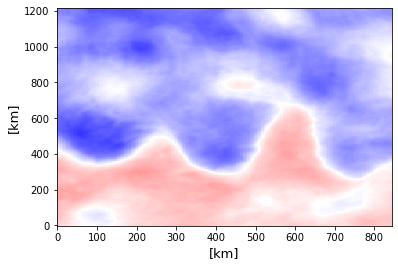

In [37]:
fig, ax = plt.subplots()

ax.pcolormesh(llc02w_H.isel(time=0).XC*1e-3, llc02w_H.isel(time=0).YC*1e-3,
              llc02w_H.isel(time=0), cmap='seismic', vmin=-1, vmax=1)

ax.set_xlabel("[km]", fontsize=13)
ax.set_ylabel("[km]", fontsize=13)

In [12]:
def _binned_agg(
    array: np.ndarray,
    indices: np.ndarray,
    num_bins: int,
    *,
    func,
    fill_value,
    dtype,
) -> np.ndarray:
    """NumPy helper function for aggregating over bins."""

    try:
        import numpy_groupies
    except ImportError:
        raise ImportError(
            "This function requires the `numpy_groupies` package to be installed. Please install it with pip or conda."
        )

    mask = np.logical_not(np.isnan(indices))
    int_indices = indices[mask].astype(int)
    shape = array.shape[: -indices.ndim] + (num_bins,)
    result = numpy_groupies.aggregate(
        int_indices,
        array[..., mask],
        func=func,
        size=num_bins,
        fill_value=fill_value,
        dtype=dtype,
        axis=-1,
    )
    return result


def _groupby_bins_agg(
    array: xr.DataArray,
    group: xr.DataArray,
    bins,
    func="sum",
    fill_value=0,
    dtype=None,
    **cut_kwargs,
) -> xr.DataArray:
    """Faster equivalent of Xarray's groupby_bins(...).sum()."""
    # https://github.com/pydata/xarray/issues/4473
    binned = pd.cut(np.ravel(group), bins, **cut_kwargs)
    new_dim_name = group.name + "_bins"
    indices = group.copy(data=binned.codes.reshape(group.shape))

    result = xr.apply_ufunc(
        _binned_agg,
        array,
        indices,
        input_core_dims=[indices.dims, indices.dims],
        output_core_dims=[[new_dim_name]],
        output_dtypes=[array.dtype],
        dask_gufunc_kwargs=dict(
            allow_rechunk=True,
            output_sizes={new_dim_name: binned.categories.size},
        ),
        kwargs={
            "num_bins": binned.categories.size,
            "func": func,
            "fill_value": fill_value,
            "dtype": dtype,
        },
        dask="parallelized",
    )
    result.coords[new_dim_name] = binned.categories
    return result


def isotropize(ps, fftdim, nfactor=4, **kwargs):
    """
    Isotropize a 2D power spectrum or cross spectrum
    by taking an azimuthal average.
    .. math::
        \text{iso}_{ps} = k_r N^{-1} \sum_{N} |\mathbb{F}(da')|^2
    where :math:`N` is the number of azimuthal bins.
    Parameters
    ----------
    ps : `xarray.DataArray`
        The power spectrum or cross spectrum to be isotropized.
    fftdim : list
        The fft dimensions overwhich the isotropization must be performed.
    nfactor : int, optional
        Ratio of number of bins to take the azimuthal averaging with the
        data size. Default is 4.
    """

    # compute radial wavenumber bins
    k = ps[fftdim[1]]
    l = ps[fftdim[0]]

    N = [k.size, l.size]
    nbins = int(min(N) / nfactor)
    freq_r = np.sqrt(k ** 2 + l ** 2).rename("freq_r")
    kr = _groupby_bins_agg(freq_r, freq_r, bins=nbins, func="mean")

    if "truncate" in kwargs:
        if truncate:
            if k.max() > l.max():
                kmax = l.max()
            else:
                kmax = k.max()
            kr = kr.where(kr <= kmax)
        else:
            msg = (
                "The flag `truncate` will be set to True by default in future version "
                + "in order to truncate the isotropic wavenumber larger than the "
                + "Nyquist wavenumber."
            )
            warnings.warn(msg, FutureWarning)

    iso_ps = (
        _groupby_bins_agg(ps, freq_r, bins=nbins, func="mean")
        .rename({"freq_r_bins": "freq_r"})
        .drop_vars("freq_r")
    )
    iso_ps.coords["freq_r"] = kr.data
    if "truncate" in kwargs:
        if truncate:
            return (iso_ps * iso_ps.freq_r).dropna("freq_r")
    else:
        return iso_ps * iso_ps.freq_r

In [47]:
Fenatlw_H = xrft.dft(xrft.dft(enatl02w_H.fillna(0.), 
                              dim=['YC','XC'], window='hann', detrend='linear', true_phase=True, true_amplitude=True
                             ).chunk({'time':-1,'freq_YC':100,'freq_XC':100}),
                     dim=['time'], window='hann', detrend='linear', true_phase=True, true_amplitude=True
                    )
Fenatlw_H = Fenatlw_H.isel(freq_time=slice(len(Fenatlw_H.freq_time)//2,None)) * 2

Fenatls_H = xrft.dft(xrft.dft(enatl02s_H.fillna(0.), 
                              dim=['YC','XC'], window='hann', detrend='linear', true_phase=True, true_amplitude=True
                             ).chunk({'time':-1,'freq_YC':100,'freq_XC':100}),
                     dim=['time'], window='hann', detrend='linear', true_phase=True, true_amplitude=True
                    )
Fenatls_H = Fenatls_H.isel(freq_time=slice(len(Fenatls_H.freq_time)//2,None)) * 2

Fenatls_H

<xarray.DataArray (freq_time: 732, freq_YC: 735, freq_XC: 607)>
dask.array<mul, shape=(732, 735, 607), dtype=complex128, chunksize=(732, 100, 100), chunktype=numpy.ndarray>
Coordinates:
  * freq_YC    (freq_YC) float64 -0.0003327 -0.0003318 ... 0.0003318 0.0003327
  * freq_XC    (freq_XC) float64 -0.0003309 -0.0003298 ... 0.0003298 0.0003309
  * freq_time  (freq_time) float64 0.0 1.897e-07 ... 0.0001385 0.0001387

In [114]:
tmp_path = f'{SCRATCH}/region02/eNATL60/'+f'SSH_omega-k-l_fma.zarr'
store_tmp = gcs.get_mapper(tmp_path)
Fenatlw_H.to_dataset(name='spectra').to_zarr(store_tmp, mode='w')
print(tmp_path)

tmp_path = f'{SCRATCH}/region02/eNATL60/'+f'SSH_omega-k-l_aso.zarr'
store_tmp = gcs.get_mapper(tmp_path)
Fenatls_H.to_dataset(name='spectra').to_zarr(store_tmp, mode='w')
print(tmp_path)

gcs://meom-ige-scratch/roxyboy/region02/eNATL60/SSH_omega-k-l_fma.zarr
gcs://meom-ige-scratch/roxyboy/region02/eNATL60/SSH_omega-k-l_aso.zarr


In [22]:
Fenatlw_H = xr.open_zarr(gcs.get_mapper(f"gcs://meom-ige-scratch/roxyboy/region02/eNATL60/SSH_omega-k-l_fma.zarr")).spectra
isoFenatlw_H = isotropize(np.abs(Fenatlw_H.chunk({'freq_time':10}))**2, 
                          ['freq_YC','freq_XC'], nfactor=4, kwargs={'truncate':True}
                         ).compute() 
Fenatls_H = xr.open_zarr(gcs.get_mapper(f"gcs://meom-ige-scratch/roxyboy/region02/eNATL60/SSH_omega-k-l_aso.zarr")).spectra
isoFenatls_H = isotropize(np.abs(Fenatls_H.chunk({'freq_time':10}))**2, 
                          ['freq_YC','freq_XC'], nfactor=4, kwargs={'truncate':True}
                         ).compute() 
isoFenatlw_H

<xarray.DataArray (freq_time: 1068, freq_r: 151)>
array([[6.72488471e+26, 2.32455877e+26, 6.49990604e+24, ...,
        4.34953461e+14, 3.43729602e+14, 3.69383292e+14],
       [9.11185808e+26, 3.42007616e+26, 1.53060231e+25, ...,
        1.00903440e+15, 1.11598729e+15, 8.90505441e+14],
       [3.21654795e+26, 1.97167022e+26, 2.16634486e+25, ...,
        1.55926069e+15, 1.69266554e+15, 1.35492026e+15],
       ...,
       [1.77814594e+19, 2.89594312e+17, 4.46652406e+15, ...,
        1.17162875e+14, 1.55256464e+14, 8.69187783e+13],
       [3.14455203e+19, 3.63627932e+17, 3.50407069e+15, ...,
        1.18333243e+14, 1.29457011e+14, 8.78492604e+13],
       [1.88542614e+19, 3.07069406e+17, 2.84486102e+15, ...,
        1.38778316e+14, 1.19614019e+14, 1.05452761e+14]])
Coordinates:
  * freq_time  (freq_time) float64 0.0 1.3e-07 2.601e-07 ... 0.0001386 0.0001388
  * freq_r     (freq_r) float64 2.068e-06 4.784e-06 ... 0.0004644 0.0004673

In [65]:
Fhycomw_H = xrft.dft(xrft.dft(hycom02w_H.fillna(0.), 
                              dim=['YC','XC'], window='hann', detrend='linear', true_phase=True, true_amplitude=True
                             ).chunk({'time':-1,'freq_YC':100,'freq_XC':100}),
                     dim=['time'], window='hann', detrend='linear', true_phase=True, true_amplitude=True
                    )
Fhycomw_H = Fhycomw_H.isel(freq_time=slice(len(Fhycomw_H.freq_time)//2,None)) * 2

Fhycoms_H = xrft.dft(xrft.dft(hycom02s_H.fillna(0.), 
                              dim=['YC','XC'], window='hann', detrend='linear', true_phase=True, true_amplitude=True
                             ).chunk({'time':-1,'freq_YC':100,'freq_XC':100}),
                     dim=['time'], window='hann', detrend='linear', true_phase=True, true_amplitude=True
                    )
Fhycoms_H = Fhycoms_H.isel(freq_time=slice(len(Fhycoms_H.freq_time)//2,None)) * 2

Fhycoms_H

<xarray.DataArray (freq_time: 1104, freq_YC: 615, freq_XC: 503)>
dask.array<mul, shape=(1104, 615, 503), dtype=complex128, chunksize=(1104, 100, 100), chunktype=numpy.ndarray>
Coordinates:
  * freq_YC    (freq_YC) float64 -0.0002747 -0.0002738 ... 0.0002738 0.0002747
  * freq_XC    (freq_XC) float64 -0.0002746 -0.0002735 ... 0.0002735 0.0002746
  * freq_time  (freq_time) float64 0.0 1.258e-07 ... 0.0001386 0.0001388

In [66]:
tmp_path = f'{SCRATCH}/region02/HYCOM50/'+f'SSH_omega-k-l_fma.zarr'
store_tmp = gcs.get_mapper(tmp_path)
Fhycomw_H.to_dataset(name='spectra').to_zarr(store_tmp, mode='w')
print(tmp_path)

tmp_path = f'{SCRATCH}/region02/HYCOM50/'+f'SSH_omega-k-l_aso.zarr'
store_tmp = gcs.get_mapper(tmp_path)
Fhycoms_H.to_dataset(name='spectra').to_zarr(store_tmp, mode='w')
print(tmp_path)

gcs://meom-ige-scratch/roxyboy/region02/HYCOM50/SSH_omega-k-l_fma.zarr
gcs://meom-ige-scratch/roxyboy/region02/HYCOM50/SSH_omega-k-l_aso.zarr


In [67]:
Fhycomw_H = xr.open_zarr(gcs.get_mapper(f"gcs://meom-ige-scratch/roxyboy/region02/HYCOM50/SSH_omega-k-l_fma.zarr")).spectra
isoFhycomw_H = isotropize(np.abs(Fhycomw_H.chunk({'freq_time':10}))**2, 
                          ['freq_YC','freq_XC'], nfactor=4, kwargs={'truncate':True}
                         ).compute() 
Fhycoms_H = xr.open_zarr(gcs.get_mapper(f"gcs://meom-ige-scratch/roxyboy/region02/HYCOM50/SSH_omega-k-l_aso.zarr")).spectra
isoFhycoms_H = isotropize(np.abs(Fhycoms_H.chunk({'freq_time':10}))**2, 
                          ['freq_YC','freq_XC'], nfactor=4, kwargs={'truncate':True}
                         ).compute() 
isoFhycomw_H

<xarray.DataArray (freq_time: 1080, freq_r: 125)>
array([[1.71000729e+27, 2.67780738e+26, 8.08740209e+24, ...,
        3.87388849e+16, 4.38714471e+16, 5.86728212e+16],
       [2.66572306e+27, 5.27779386e+26, 1.53181544e+25, ...,
        8.13628240e+16, 8.98986039e+16, 1.62678096e+17],
       [1.08373916e+27, 3.72618241e+26, 1.84335114e+25, ...,
        1.22047472e+17, 1.35201436e+17, 2.02439797e+17],
       ...,
       [1.45402114e+18, 8.36800095e+15, 2.58368114e+15, ...,
        7.08961697e+16, 9.47590310e+16, 9.33399259e+16],
       [2.25972319e+18, 9.60649805e+15, 2.95976459e+15, ...,
        7.12046187e+16, 9.43511779e+16, 9.12992613e+16],
       [6.20993837e+18, 1.28410483e+16, 2.02193020e+15, ...,
        7.26262832e+16, 9.80358531e+16, 8.84733387e+16]])
Coordinates:
  * freq_time  (freq_time) float64 0.0 1.286e-07 ... 0.0001386 0.0001388
  * freq_r     (freq_r) float64 2.055e-06 4.76e-06 ... 0.0003836 0.0003866

In [13]:
def _stack_chunks(da, dim, suffix="_segment"):
    """Reshape a DataArray so there is only one chunk along dimension `dim`"""
    data = da.data
    attr = da.attrs
    newdims = []
    newcoords = {}
    newshape = []
    for d in da.dims:
        if d in dim:
            axis_num = da.get_axis_num(d)
            if np.diff(da.chunks[axis_num]).sum() != 0:
                raise ValueError("Chunk lengths need to be the same.")
            n = len(da[d])
            chunklen = da.chunks[axis_num][0]
            coord_rs = da[d].data.reshape((int(n / chunklen), int(chunklen)))
            newdims.append(d + suffix)
            newdims.append(d)
            newshape.append(int(n / chunklen))
            newshape.append(int(chunklen))
            newcoords[d + suffix] = range(int(n / chunklen))
            newcoords[d] = coord_rs[0]
        else:
            newdims.append(d)
            newshape.append(len(da[d]))
            newcoords[d] = da[d].data

    return    xr.DataArray(
                data.reshape(newshape), dims=newdims, coords=newcoords, attrs=attr
    )
    
def _detrend(da, dim, detrend_type="constant"):
    """
    Detrend a DataArray
    Parameters
    ----------
    da : xarray.DataArray
        The data to detrend
    dim : str or list
        Dimensions along which to apply detrend.
        Can be either one dimension or a list with two dimensions.
        Higher-dimensional detrending is not supported.
        If dask data are passed, the data must be chunked along dim.
    detrend_type : {'constant', 'linear'}
        If ``constant``, a constant offset will be removed from each dim.
        If ``linear``, a linear least-squares fit will be estimated and removed
        from the data.
    Returns
    -------
    da : xarray.DataArray
        The detrended data.
    Notes
    -----
    This function will act lazily in the presence of dask arrays on the
    input.
    """

    if dim is None:
        dim = list(da.dims)
    else:
        if isinstance(dim, str):
            dim = [dim]

    if detrend_type not in ["constant", "linear", None]:
        raise NotImplementedError(
            "%s is not a valid detrending option. Valid "
            "options are: 'constant','linear', or None." % detrend_type
        )

    if detrend_type is None:
        return da
    elif detrend_type == "constant":
        return da - da.mean(dim=dim)
    elif detrend_type == "linear":
        data = da.data
        axis_num = [da.get_axis_num(d) for d in dim]
        chunks = getattr(data, "chunks", None)
        if chunks:
            axis_chunks = [data.chunks[a] for a in axis_num]
            if not all([len(ac) == 1 for ac in axis_chunks]):
                raise ValueError("Contiguous chunks required for detrending.")
        if len(dim) == 1:
            dt = xr.apply_ufunc(
                sps.detrend,
                da,
                axis_num[0],
                output_dtypes=[da.dtype],
                dask="parallelized",
            )
        elif len(dim) == 2:
            dt = xr.apply_ufunc(
                _detrend_2d_ufunc,
                da,
                input_core_dims=[dim],
                output_core_dims=[dim],
                output_dtypes=[da.dtype],
                vectorize=True,
                dask="parallelized",
            )
        else:  # pragma: no cover
            raise NotImplementedError(
                "Only 1D and 2D detrending are implemented so far."
            )

    return dt


def _detrend_2d_ufunc(arr):
    assert arr.ndim == 2
    N = arr.shape

    col0 = np.ones(N[0] * N[1])
    col1 = np.repeat(np.arange(N[0]), N[1]) + 1
    col2 = np.tile(np.arange(N[1]), N[0]) + 1
    G = np.stack([col0, col1, col2]).transpose()

    d_obs = np.reshape(arr, (N[0] * N[1], 1))
    m_est = np.dot(np.dot(spl.inv(np.dot(G.T, G)), G.T), d_obs)
    d_est = np.dot(G, m_est)
    linear_fit = np.reshape(d_est, N)
    return arr - linear_fit

In [14]:
daw = _detrend(_stack_chunks(gigatl02w_H.isel(YC=slice(None,-1),XC=slice(None,-1)
                                             ).fillna(0.).chunk({'YC':len(gigatl02w_H.YC)//2,
                                                                 'XC':len(gigatl02w_H.XC)//2}),
                             ['YC','XC']),
               ['YC','XC'], detrend_type="linear")
Fgigatlw_H = xrft.dft(daw, dim=['YC','XC'],  
                      window='hann', true_phase=True, true_amplitude=True
                     ).chunk({'time':-1,'freq_YC':100,'freq_XC':100})

Fgigatlw_H = xrft.dft(Fgigatlw_H,
                      dim=['time'], window='hann', detrend='linear', true_phase=True, true_amplitude=True
                     )
Fgigatlw_H = Fgigatlw_H.isel(freq_time=slice(len(Fgigatlw_H.freq_time)//2,None)).chunk({'freq_time':10}) * 2
Fgigatlw_H

,Array,Chunk
Bytes,34.21 GB,1.60 MB
Shape,"(1140, 2, 2, 705, 665)","(10, 1, 1, 100, 100)"
Count,97702 Tasks,25536 Chunks
Type,complex128,numpy.ndarray


In [15]:
tmp_path = f'{SCRATCH}/region02/GIGATL/'+f'SSH_omega-k-l_fma.zarr'
store_tmp = gcs.get_mapper(tmp_path)
Fgigatlw_H.to_dataset(name='spectra').to_zarr(store_tmp, mode='w')
print(tmp_path)

gcs://meom-ige-scratch/roxyboy/region02/GIGATL/SSH_omega-k-l_fma.zarr


In [17]:
das = _detrend(_stack_chunks(gigatl02s_H.isel(YC=slice(None,-1),XC=slice(None,-1)
                                             ).fillna(0.).chunk({'YC':len(gigatl02s_H.YC)//2,
                                                                 'XC':len(gigatl02s_H.XC)//2}),
                             ['YC','XC']),
               ['YC','XC'], detrend_type="linear")
Fgigatls_H = xrft.dft(das, dim=['YC','XC'],  
                      window='hann', true_phase=True, true_amplitude=True
                     ).chunk({'time':-1,'freq_YC':100,'freq_XC':100})

Fgigatls_H = xrft.dft(Fgigatls_H,
                      dim=['time'], window='hann', detrend='linear', true_phase=True, true_amplitude=True
                     )
Fgigatls_H = Fgigatls_H.isel(freq_time=slice(len(Fgigatls_H.freq_time)//2,None)).chunk({'freq_time':10}) * 2
Fgigatls_H

,Array,Chunk
Bytes,34.21 GB,1.60 MB
Shape,"(1140, 2, 2, 705, 665)","(10, 1, 1, 100, 100)"
Count,97702 Tasks,25536 Chunks
Type,complex128,numpy.ndarray


In [18]:
tmp_path = f'{SCRATCH}/region02/GIGATL/'+f'SSH_omega-k-l_aso.zarr'
store_tmp = gcs.get_mapper(tmp_path)
Fgigatls_H.to_dataset(name='spectra').to_zarr(store_tmp, mode='w')
print(tmp_path)

gcs://meom-ige-scratch/roxyboy/region02/GIGATL/SSH_omega-k-l_aso.zarr


In [20]:
Fgigatlw_H = xr.open_zarr(gcs.get_mapper(f"gcs://meom-ige-scratch/roxyboy/region02/GIGATL/SSH_omega-k-l_fma.zarr")).spectra
isoFgigatlw_H = isotropize((np.abs(Fgigatlw_H)**2).mean(['YC_segment','XC_segment']), 
                           ['freq_YC','freq_XC'], nfactor=4, kwargs={'truncate':True}
                          ).compute()
isoFgigatlw_H

<xarray.DataArray (freq_time: 1140, freq_r: 166)>
array([[1.30400486e+26, 2.51631358e+25, 8.08841487e+23, ...,
        3.44340481e+13, 3.24242293e+13, 2.77396664e+13],
       [2.12332498e+26, 6.39670910e+25, 1.57548628e+24, ...,
        6.43348442e+13, 6.68948755e+13, 4.58307109e+13],
       [1.77045698e+26, 8.39316403e+25, 1.98720125e+24, ...,
        8.05220596e+13, 7.97626451e+13, 6.46452118e+13],
       ...,
       [3.01922374e+17, 2.29961945e+15, 1.02875430e+15, ...,
        3.95183677e+12, 3.08541508e+12, 3.69243201e+12],
       [1.95198182e+17, 1.88266247e+15, 9.94906889e+14, ...,
        4.16937758e+12, 3.51141461e+12, 4.28381563e+12],
       [2.67428144e+17, 1.85562796e+15, 1.03991751e+15, ...,
        4.53828452e+12, 3.78033406e+12, 4.33816212e+12]])
Coordinates:
  * freq_time  (freq_time) float64 0.0 1.218e-07 ... 0.0001386 0.0001388
  * freq_r     (freq_r) float64 2.745e-06 6.541e-06 ... 0.0007005 0.0007047

In [21]:
Fgigatls_H = xr.open_zarr(gcs.get_mapper(f"gcs://meom-ige-scratch/roxyboy/region02/GIGATL/SSH_omega-k-l_aso.zarr")).spectra
isoFgigatls_H = isotropize((np.abs(Fgigatls_H)**2).mean(['YC_segment','XC_segment']), 
                           ['freq_YC','freq_XC'], nfactor=4, kwargs={'truncate':True}
                          ).compute()
isoFgigatls_H

<xarray.DataArray (freq_time: 1140, freq_r: 166)>
array([[3.04875584e+26, 5.64893519e+25, 7.59840851e+23, ...,
        1.18008683e+12, 1.33481077e+12, 1.64408303e+12],
       [5.69814209e+26, 8.76587241e+25, 1.58154528e+24, ...,
        2.54995976e+12, 2.38957682e+12, 3.02927730e+12],
       [3.98932308e+26, 7.70936041e+25, 2.11399305e+24, ...,
        3.17290792e+12, 3.00343868e+12, 3.41153828e+12],
       ...,
       [5.47765055e+16, 1.86228417e+15, 1.31164598e+15, ...,
        9.26402406e+11, 9.45549902e+11, 9.54373967e+11],
       [1.79348424e+17, 1.84447900e+15, 1.36462524e+15, ...,
        1.01326501e+12, 1.05206077e+12, 9.45492755e+11],
       [1.03224659e+17, 2.28313434e+15, 1.63630708e+15, ...,
        1.12395209e+12, 1.03475638e+12, 7.90107801e+11]])
Coordinates:
  * freq_time  (freq_time) float64 0.0 1.218e-07 ... 0.0001386 0.0001388
  * freq_r     (freq_r) float64 2.745e-06 6.541e-06 ... 0.0007005 0.0007047

In [45]:
Fllcw_H = xrft.dft(xrft.dft(llc02w_H.fillna(0.), 
                            dim=['YC','XC'], window='hann', detrend='linear', true_phase=True, true_amplitude=True
                           ).chunk({'time':-1,'freq_YC':100,'freq_XC':100}),
                   dim=['time'], window='hann', detrend='linear', true_phase=True, true_amplitude=True
                  )
Fllcw_H = Fllcw_H.isel(freq_time=slice(len(Fllcw_H.freq_time)//2,None)) * 2

Fllcs_H = xrft.dft(xrft.dft(llc02s_H.fillna(0.), 
                            dim=['YC','XC'], window='hann', detrend='linear', true_phase=True, true_amplitude=True
                           ).chunk({'time':-1,'freq_YC':100,'freq_XC':100}),
                   dim=['time'], window='hann', detrend='linear', true_phase=True, true_amplitude=True
                  )
Fllcs_H = Fllcs_H.isel(freq_time=slice(len(Fllcs_H.freq_time)//2,None)) * 2

Fllcs_H

<xarray.DataArray (freq_time: 1104, freq_YC: 321, freq_XC: 242)>
dask.array<mul, shape=(1104, 321, 242), dtype=complex128, chunksize=(1104, 100, 100), chunktype=numpy.ndarray>
Coordinates:
  * freq_YC    (freq_YC) float64 -0.0001317 -0.0001309 ... 0.0001309 0.0001317
  * freq_XC    (freq_XC) float64 -0.0001432 -0.000142 ... 0.0001408 0.000142
  * freq_time  (freq_time) float64 0.0 1.258e-07 ... 0.0001386 0.0001388

In [46]:
tmp_path = f'{SCRATCH}/region02/LLC4320/'+f'SSH_omega-k-l_fma.zarr'
print(tmp_path)
store_tmp = gcs.get_mapper(tmp_path)
Fllcw_H.to_dataset(name='spectra').to_zarr(store_tmp, mode='w')

In [47]:
tmp_path = f'{SCRATCH}/region02/LLC4320/'+f'SSH_omega-k-l_aso.zarr'
print(tmp_path)
store_tmp = gcs.get_mapper(tmp_path)
Fllcs_H.to_dataset(name='spectra').to_zarr(store_tmp, mode='w')

gcs://meom-ige-scratch/roxyboy/region02/LLC4320/SSH_omega-k-l_aso.zarr


In [48]:
Fllcw_H = xr.open_zarr(gcs.get_mapper(f"gcs://meom-ige-scratch/roxyboy/region02/LLC4320/SSH_omega-k-l_fma.zarr")).spectra
isoFllcw_H = isotropize(np.abs(Fllcw_H.chunk({'freq_time':10}))**2, 
                        ['freq_YC','freq_XC'], nfactor=4, kwargs={'truncate':True}
                       ).compute() 
Fllcs_H = xr.open_zarr(gcs.get_mapper(f"gcs://meom-ige-scratch/roxyboy/region02/LLC4320/SSH_omega-k-l_aso.zarr")).spectra
isoFllcs_H = isotropize(np.abs(Fllcs_H.chunk({'freq_time':10}))**2, 
                        ['freq_YC','freq_XC'], nfactor=4, kwargs={'truncate':True}
                       ).compute() 
isoFllcw_H

<xarray.DataArray (freq_time: 1080, freq_r: 60)>
array([[2.25408090e+26, 1.48096372e+26, 8.94851963e+24, ...,
        7.13511164e+16, 7.71466350e+16, 6.53640859e+16],
       [2.74318156e+26, 2.32661192e+26, 1.60491767e+25, ...,
        1.82029278e+17, 1.97728342e+17, 1.90019706e+17],
       [9.27569309e+25, 1.23635020e+26, 1.71268760e+25, ...,
        3.22450181e+17, 2.80941838e+17, 2.91548025e+17],
       ...,
       [4.79784757e+18, 8.39100891e+15, 2.10297540e+15, ...,
        2.80659635e+15, 2.42753209e+15, 1.76710934e+15],
       [4.48211696e+18, 6.61258727e+15, 1.68225264e+15, ...,
        3.59848565e+15, 2.23498339e+15, 1.87081288e+15],
       [1.37810693e+18, 3.29887130e+15, 1.16422032e+15, ...,
        3.14926479e+15, 2.31367995e+15, 2.04827997e+15]])
Coordinates:
  * freq_time  (freq_time) float64 0.0 1.286e-07 ... 0.0001386 0.0001388
  * freq_r     (freq_r) float64 2.044e-06 5.011e-06 ... 0.0001895 0.0001925

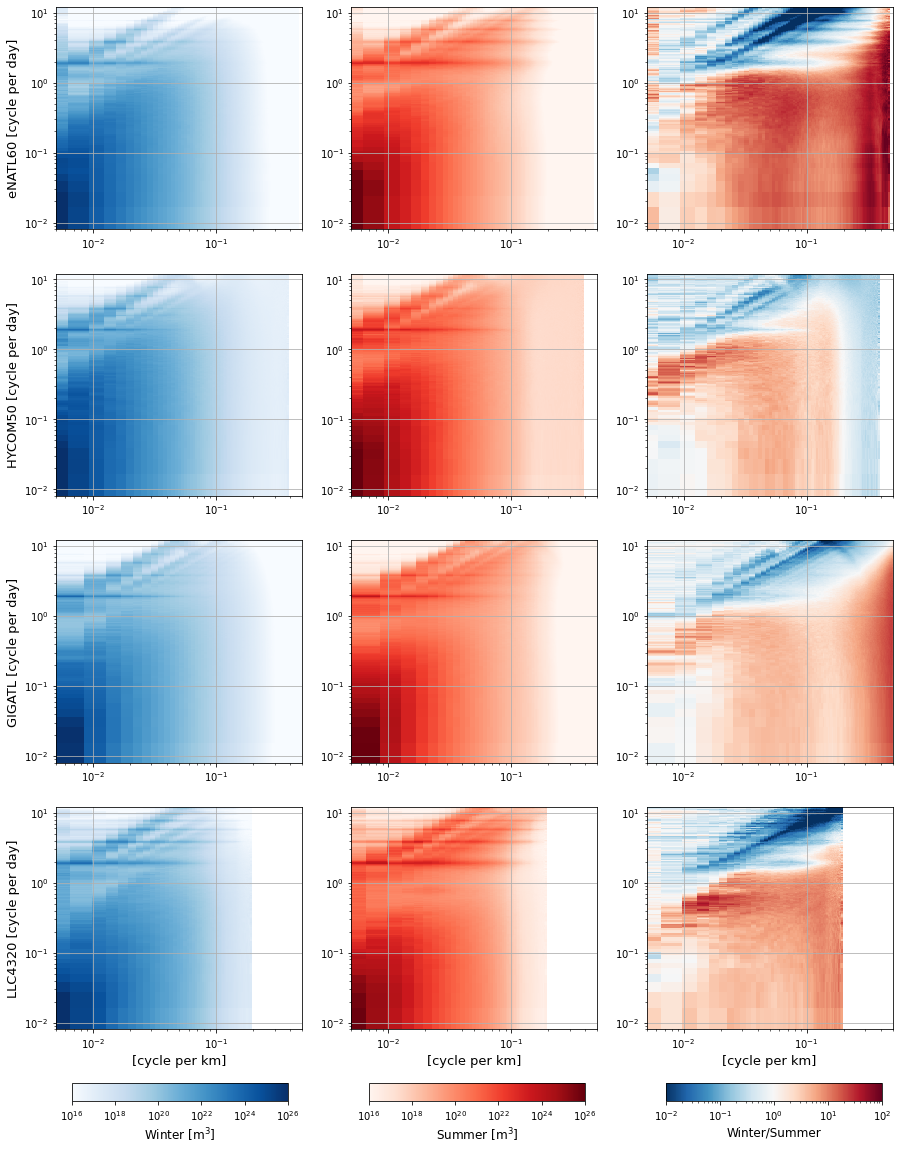

In [68]:
fig, axes = plt.subplots(figsize=(15,20), nrows=4, ncols=3)
# fig.set_tight_layout(True)
ax00 = axes[0,0]
ax01 = axes[0,1]
ax02 = axes[0,2]
ax10 = axes[1,0]
ax11 = axes[1,1]
ax12 = axes[1,2]
ax20 = axes[2,0]
ax21 = axes[2,1]
ax22 = axes[2,2]
ax30 = axes[3,0]
ax31 = axes[3,1]
ax32 = axes[3,2]


im0 = ax00.pcolormesh(isoFenatlw_H.freq_r.isel(freq_r=slice(1,None))*1e3,
                      isoFenatlw_H.freq_time.isel(freq_time=slice(1,None))*86400,
                      isoFenatlw_H.isel(freq_r=slice(1,None),freq_time=slice(1,None)), 
                      cmap='Blues', norm=clr.LogNorm(vmin=1e16, vmax=1e26), 
                      rasterized=True)
ax10.pcolormesh(isoFhycomw_H.freq_r.isel(freq_r=slice(1,None))*1e3,
                isoFhycomw_H.freq_time.isel(freq_time=slice(1,None))*86400,
                isoFhycomw_H.isel(freq_r=slice(1,None),freq_time=slice(1,None)), 
                cmap='Blues', norm=clr.LogNorm(vmin=1e16, vmax=1e26), 
                rasterized=True)
ax20.pcolormesh(isoFgigatlw_H.freq_r.isel(freq_r=slice(1,None))*1e3,
                isoFgigatlw_H.freq_time.isel(freq_time=slice(1,None))*86400,
                isoFgigatlw_H.isel(freq_r=slice(1,None),freq_time=slice(1,None)), 
                cmap='Blues', norm=clr.LogNorm(vmin=1e16, vmax=1e26), 
                rasterized=True)
ax30.pcolormesh(isoFllcw_H.freq_r.isel(freq_r=slice(1,None))*1e3,
                isoFllcw_H.freq_time.isel(freq_time=slice(1,None))*86400,
                isoFllcw_H.isel(freq_r=slice(1,None),freq_time=slice(1,None)), 
                cmap='Blues', norm=clr.LogNorm(vmin=1e16, vmax=1e26),
                rasterized=True)

im1 = ax01.pcolormesh(isoFenatls_H.freq_r.isel(freq_r=slice(1,None))*1e3, 
                      isoFenatls_H.freq_time.isel(freq_time=slice(1,None))*86400, 
                      isoFenatls_H.isel(freq_r=slice(1,None),freq_time=slice(1,None)), 
                      cmap='Reds', norm=clr.LogNorm(vmin=1e16, vmax=1e26), 
                      rasterized=True)
ax11.pcolormesh(isoFhycoms_H.freq_r.isel(freq_r=slice(1,None))*1e3,
                isoFhycoms_H.freq_time.isel(freq_time=slice(1,None))*86400,
                isoFhycoms_H.isel(freq_r=slice(1,None),freq_time=slice(1,None)), 
                cmap='Reds', norm=clr.LogNorm(vmin=1e16, vmax=1e26), 
                rasterized=True)
ax21.pcolormesh(isoFgigatls_H.freq_r.isel(freq_r=slice(1,None))*1e3,
                isoFgigatls_H.freq_time.isel(freq_time=slice(1,None))*86400,
                isoFgigatls_H.isel(freq_r=slice(1,None),freq_time=slice(1,None)), 
                cmap='Reds', norm=clr.LogNorm(vmin=1e16, vmax=1e26), 
                rasterized=True)
ax31.pcolormesh(isoFllcs_H.freq_r.isel(freq_r=slice(1,None))*1e3, 
                isoFllcs_H.freq_time.isel(freq_time=slice(1,None))*86400, 
                isoFllcs_H.isel(freq_r=slice(1,None),freq_time=slice(1,None)), 
                cmap='Reds', norm=clr.LogNorm(vmin=1e16, vmax=1e26),
                rasterized=True)

im2 = ax02.pcolormesh(isoFenatlw_H.freq_r.isel(freq_r=slice(1,None))*1e3, 
                      isoFenatlw_H.freq_time.isel(freq_time=slice(1,None))*86400, 
                      (isoFenatlw_H.isel(freq_r=slice(1,None),freq_time=slice(1,None))
                       / isoFenatls_H.isel(freq_r=slice(1,None),freq_time=slice(1,None)
                                          ).interp(freq_time=isoFenatlw_H.freq_time, 
                                                   kwargs={'fill_value':'extrapolate'})
                      ), 
                      cmap='RdBu_r', norm=clr.LogNorm(vmin=1e-2, vmax=1e2), 
                      rasterized=True)
ax12.pcolormesh(isoFhycomw_H.freq_r.isel(freq_r=slice(1,None))*1e3,
                isoFhycomw_H.freq_time.isel(freq_time=slice(1,None))*86400,
                (isoFhycomw_H.isel(freq_r=slice(1,None),freq_time=slice(1,None))
                 / isoFhycoms_H.isel(freq_r=slice(1,None),freq_time=slice(1,None)
                                    ).interp(freq_time=isoFhycomw_H.freq_time.isel(freq_time=slice(1,None)))
                ), 
                cmap='RdBu_r', norm=clr.LogNorm(vmin=1e-2, vmax=1e2), 
                rasterized=True)
ax22.pcolormesh(isoFgigatlw_H.freq_r.isel(freq_r=slice(1,None))*1e3,
                isoFgigatlw_H.freq_time.isel(freq_time=slice(1,None))*86400,
                (isoFgigatlw_H.isel(freq_r=slice(1,None),freq_time=slice(1,None))
                 / isoFgigatls_H.isel(freq_r=slice(1,None),freq_time=slice(1,None)
                                     ).interp(freq_time=isoFgigatlw_H.freq_time.isel(freq_time=slice(1,None)))
                ), 
                cmap='RdBu_r', norm=clr.LogNorm(vmin=1e-2, vmax=1e2), 
                rasterized=True)
ax32.pcolormesh(isoFllcw_H.freq_r.isel(freq_r=slice(1,None))*1e3,
                isoFllcw_H.freq_time.isel(freq_time=slice(1,None))*86400,
                (isoFllcw_H.isel(freq_r=slice(1,None),freq_time=slice(1,None))
                 / isoFllcs_H.isel(freq_r=slice(1,None),freq_time=slice(1,None)
                                  ).interp(freq_time=isoFllcw_H.freq_time.isel(freq_time=slice(1,None)))
                ), 
                cmap='RdBu_r', norm=clr.LogNorm(vmin=1e-2, vmax=1e2), 
                rasterized=True)


ax00.set_xlim([5e-3,5e-1])
ax01.set_xlim([5e-3,5e-1])
ax02.set_xlim([5e-3,5e-1])
ax10.set_xlim([5e-3,5e-1])
ax11.set_xlim([5e-3,5e-1])
ax12.set_xlim([5e-3,5e-1])
ax20.set_xlim([5e-3,5e-1])
ax21.set_xlim([5e-3,5e-1])
ax22.set_xlim([5e-3,5e-1])
ax30.set_xlim([5e-3,5e-1])
ax31.set_xlim([5e-3,5e-1])
ax32.set_xlim([5e-3,5e-1])
ax00.set_ylim([8e-3,None])
ax01.set_ylim([8e-3,None])
ax02.set_ylim([8e-3,None])
ax10.set_ylim([8e-3,None])
ax11.set_ylim([8e-3,None])
ax12.set_ylim([8e-3,None])
ax20.set_ylim([8e-3,None])
ax21.set_ylim([8e-3,None])
ax22.set_ylim([8e-3,None])
ax30.set_ylim([8e-3,None])
ax31.set_ylim([8e-3,None])
ax32.set_ylim([8e-3,None])

ax00.set_xscale('log')
ax00.set_yscale('log')
ax01.set_xscale('log')
ax01.set_yscale('log')
ax02.set_xscale('log')
ax02.set_yscale('log')
ax10.set_xscale('log')
ax10.set_yscale('log')
ax11.set_xscale('log')
ax11.set_yscale('log')
ax12.set_xscale('log')
ax12.set_yscale('log')
ax20.set_xscale('log')
ax20.set_yscale('log')
ax21.set_xscale('log')
ax21.set_yscale('log')
ax22.set_xscale('log')
ax22.set_yscale('log')
ax30.set_xscale('log')
ax30.set_yscale('log')
ax31.set_xscale('log')
ax31.set_yscale('log')
ax32.set_xscale('log')
ax32.set_yscale('log')

ax30.set_xlabel(r"[cycle per km]", fontsize=13)
ax31.set_xlabel(r"[cycle per km]", fontsize=13)
ax32.set_xlabel(r"[cycle per km]", fontsize=13)
ax00.set_ylabel(r"eNATL60 [cycle per day]", fontsize=13)
ax10.set_ylabel(r"HYCOM50 [cycle per day]", fontsize=13)
ax20.set_ylabel(r"GIGATL [cycle per day]", fontsize=13)
ax30.set_ylabel(r"LLC4320 [cycle per day]", fontsize=13)

ax00.grid(True)
ax01.grid(True)
ax02.grid(True)
ax10.grid(True)
ax11.grid(True)
ax12.grid(True)
ax20.grid(True)
ax21.grid(True)
ax22.grid(True)
ax30.grid(True)
ax31.grid(True)
ax32.grid(True)

fig.subplots_adjust(bottom=.17, hspace=.2) 
cbax0 = fig.add_axes([0.14, 0.125, 0.2, 0.013])
cbar0 = fig.colorbar(im0, orientation='horizontal', cax=cbax0)
cbar0.set_label(r"Winter [m$^3$]", fontsize=12)

cbax1 = fig.add_axes([0.415, 0.125, 0.2, 0.013])
cbar1 = fig.colorbar(im1, orientation='horizontal', cax=cbax1)
cbar1.set_label(r"Summer [m$^3$]", fontsize=12)

cbax2 = fig.add_axes([0.69, 0.125, 0.2, 0.013])
cbar2 = fig.colorbar(im2, orientation='horizontal', cax=cbax2)
cbar2.set_label(r"Winter/Summer", fontsize=12)

plt.savefig('/home/jovyan/Figures/omega-k-spectra_surfH_02.pdf')

In [ ]:
client.close()